# Basic regression with Gaussian Processes

In this notebook we use the Python library [GPy](https://github.com/SheffieldML/GPy) for Gaussian processes and apply them to a regression problem in the [Airfoil self-noise](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) dataset from UCI Machine Learning Repository.

In [1]:
import pandas as pd
import numpy as np
import GPy
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Download the dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat

--2018-12-18 20:56:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59984 (59K) [text/plain]
Saving to: 'airfoil_self_noise.dat'

airfoil_self_noise. 100%[===================>]  58.58K  64.0KB/s    in 0.9s    

2018-12-18 20:56:10 (64.0 KB/s) - 'airfoil_self_noise.dat' saved [59984/59984]



In [3]:
# View the first rows
!head airfoil_self_noise.dat

As explained on the repository web page, the data columns are:
1. Frequency, in Hertzs. 
2. Angle of attack, in degrees. 
3. Chord length, in meters. 
4. Free-stream velocity, in meters per second. 
5. Suction side displacement thickness, in meters. 

The output column is:
6. Scaled sound pressure level, in decibels. 

In [4]:
# Load the data into a pandas dataframe
data = pd.read_csv('airfoil_self_noise.dat', 
                   sep='\t', 
                   names=['frequency',
                          'angle_of_attack',
                          'chord_length',
                          'free-stream_velocity',
                          'suction_side_displacement_thickness',
                          'sound_pressure'])

In [5]:
data.head()

,frequency,angle_of_attack,chord_length,free-stream_velocity,suction_side_displacement_thickness,sound_pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
frequency                              1503 non-null int64
angle_of_attack                        1503 non-null float64
chord_length                           1503 non-null float64
free-stream_velocity                   1503 non-null float64
suction_side_displacement_thickness    1503 non-null float64
sound_pressure                         1503 non-null float64
dtypes: float64(5), int64(1)
memory usage: 70.5 KB


### Gaussian processes, very briefly

By a Gaussian process we mean a collection of random variables $f(\mathbf{x})$ indexed by $\mathbf{x} \in \mathbb{R}^d$ so that any finite number of them has jointly Gaussian distribution. To specify a Gaussian process, it suffices to define its covariance function
$$
k(\mathbf{x}_p, \mathbf{x}_q) = \mathbb{E} [ f(\mathbf{x}_p) \, f(\mathbf{x}_q) ] , \quad \mathbf{x}_p,\mathbf{x}_q \in \mathbb{R}^d.
$$
Here we assume that each random variable has zero mean. We will use the squared exponential (or RBF) kernel
$$
k(\mathbf{x}_p,\mathbf{x}_q) = \sigma_f^2 \exp \Big( - \frac{\| \mathbf{x}_p - \mathbf{x}_q \|^2}{2\ell^2} \Big) ,
$$
where $\ell$ and $\sigma_f^2$ are the length-scale and signal variance parameters, respectively. 

Given an indexed dataset $X\subset \mathbb{R}^d$ of size $n$, we model the observations $y$ at points $\mathbf{x} \in X$ by
$$
y = f(\mathbf{x}) + \varepsilon ,
$$
where $\varepsilon$ is i.i.d. Gaussian noise with variance $\sigma_n^2$.


Denoting by $K$ the $n\times n$ matrix with entries $k(\mathbf{x}_p, \mathbf{x}_q)$, the log marginal likelihood becomes
$$
\log p( \, \mathbf{y} \, | \, X, \ell, \sigma_f^2, \sigma_n^2 \, ) = -\frac{1}{2} \mathbf{y}^\top (K + \sigma_n^2 I)^{-1} \mathbf{y} -\frac{1}{2} \log \, | \, K + \sigma_n^2 I \, | \, - \frac{n}{2} \log 2\pi
$$

We will optimize the parameters $\ell$, $\sigma_f^2$ and $\sigma_n^2$ by maximizing the likelihood above.

### Data preparation

In [7]:
# Split the data into training and testing sets (with shuffling)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='sound_pressure'), 
                                                    data[['sound_pressure']], 
                                                    shuffle=True,
                                                    test_size=0.3)

In [8]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Single feature model

In order to more easily visualize the model we project the data into a one-dimensional feature space.

In [9]:
# Use PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [10]:
# Choose the squared exponential kernel with observation noise. Here variance = \sigma_f^2, lengthscale = \ell.
kernel_1d = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

In [11]:
# Create a regression model with normalized targets. Here noise_var = \sigma_n^2.
model_1d = GPy.models.GPRegression(X_train_pca, y_train.values, kernel_1d, normalizer=True, noise_var=1.)

In [12]:
from IPython.display import display
display(model_1d)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


{'dataplot': [<matplotlib.collections.PathCollection at 0x11363a240>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x11363a0f0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x11363a748>]}

 /anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


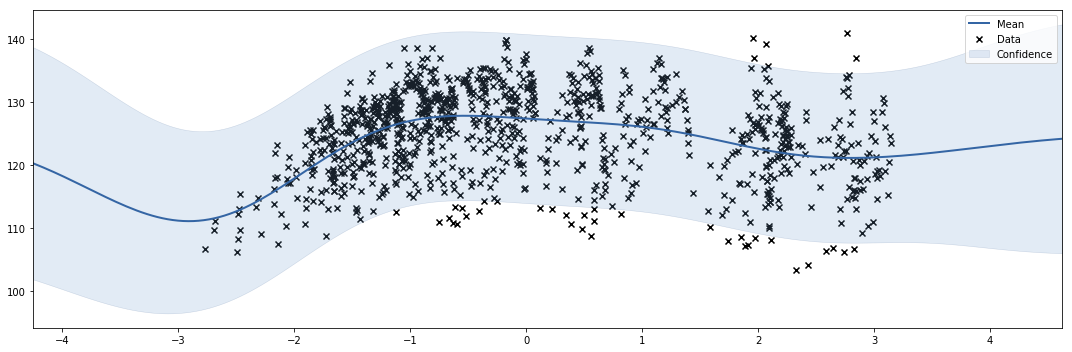

In [13]:
model_1d.plot(figsize=(15,5))

We then optimize the parameters $\ell$, $\sigma_f^2$ and $\sigma_n^2$ by maximizing the log marginal likelihood.

In [14]:
model_1d.optimize(messages=True)

{'dataplot': [<matplotlib.collections.PathCollection at 0x10987c3c8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x10987c320>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x10987c898>]}

 /anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


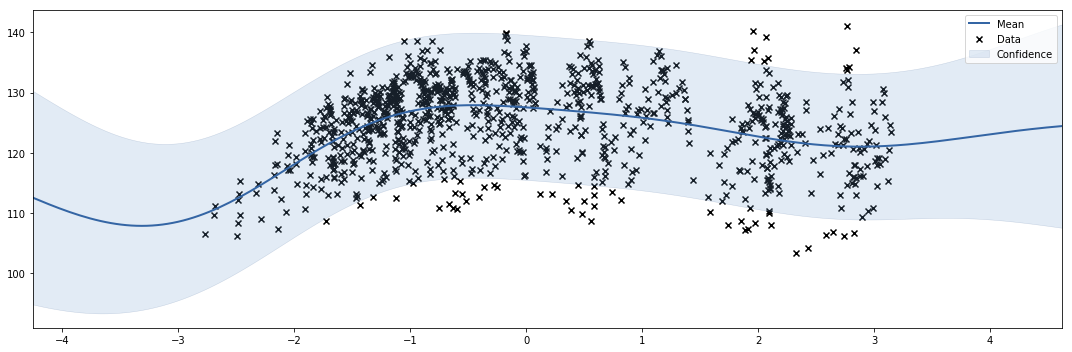

In [15]:
model_1d.plot(figsize=(15,5))

We turn to the test set for model evaluation.

 /anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


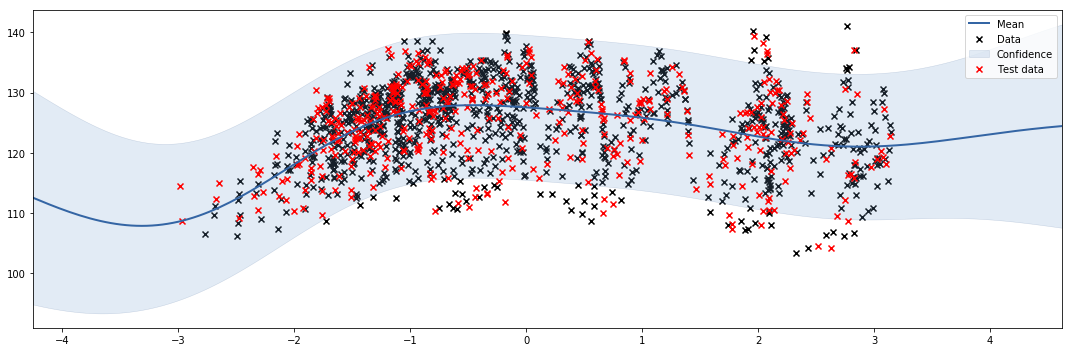

In [16]:
model_1d.plot(figsize=(15,5))
plt.scatter(X_test_pca, y_test, c='r', marker='x', label='Test data')
plt.legend()

In [17]:
# Predict
y_pred, y_pred_var = model_1d.predict(X_test_pca)

In [18]:
# Create a dataframe for prediction results
results_1d = pd.DataFrame(index=y_test.index)
results_1d['true'] = y_test.values
results_1d['pred'] = np.round(y_pred,3)
results_1d['pred_var'] = np.round(y_pred_var,3)

In [19]:
# Include lower and upper endpoints of the prediction interval
results_1d['pred_lower'] = results_1d['pred'] - 2.0 * np.round(np.sqrt(results_1d['pred_var']),3)
results_1d['pred_upper'] = results_1d['pred'] + 2.0 * np.round(np.sqrt(results_1d['pred_var']),3)

In [20]:
# 95% of our predictions should be within this interval
within_interval = (results_1d['pred_lower'] <= results_1d['true']) & (results_1d['true'] <= results_1d['pred_upper'])
results_1d['within_2sigma'] = np.where(within_interval, True, False)

In [21]:
results_1d.head()

,true,pred,pred_var,pred_lower,pred_upper,within_2sigma
1205,124.356,122.804,37.850,110.500,135.108,True
746,134.556,126.845,37.708,114.563,139.127,True
694,129.744,121.507,37.858,109.201,133.813,True
340,120.419,126.624,37.708,114.342,138.906,True
377,131.221,127.824,37.721,115.540,140.108,True


Our regression model gives probabilistic predictions and we want to know if the variances of these predictive distributions are correct on average. We will therefore compare the average prediction variance and mean squared error on the test set to see if they are about the same. About 95% of the observations in the test set should be within the $2\sigma$ prediction interval.

In [22]:
from sklearn.metrics import mean_squared_error

# Model evaluation
avg_pred_var = results_1d['pred_var'].mean()
print('Average prediction variance on test set: {}'.format(np.round(avg_pred_var,2)))
mse = mean_squared_error(results_1d['true'], results_1d['pred'])
print('Mean squared error on test set: {}'.format(np.round(mse), 2))
twosigmapercent = 100*results_1d['within_2sigma'].mean()
print('Percentage of test instances within 2 sigma prediction interval: {}%'.format(np.round(twosigmapercent,2)))

Average prediction variance on test set: 37.85
Mean squared error on test set: 39.0
Percentage of test instances within 2 sigma prediction interval: 94.68%


### Multifeature model

We then use all the five features for our GP model.

In [23]:
# Choose the squared exponential kernel with observation noise. Here variance = \sigma_f^2, lengthscale = \ell.
kernel = GPy.kern.RBF(input_dim=5, variance=1., lengthscale=1.)

In [24]:
# Create a regression model with normalized targets. Here noise_var = \sigma_n^2.
model = GPy.models.GPRegression(X_train_scaled, y_train.values, kernel, normalizer=True, noise_var=1.)

In [25]:
display(model)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [26]:
# Optimize the parameters for length-scale, and signal and noise variance
model.optimize(messages=True)

Evaluate on the test set.

In [27]:
# Predict
y_pred, y_pred_var = model.predict(X_test_scaled)

In [28]:
# Create a dataframe for prediction results
results = pd.DataFrame(index=y_test.index)
results['true'] = y_test.values
results['pred'] = np.round(y_pred,3)
results['pred_var'] = np.round(y_pred_var,3)

In [29]:
# Include lower and upper endpoints of the prediction interval
results['pred_lower'] = results['pred'] - 2.0 * np.round(np.sqrt(results['pred_var']),3)
results['pred_upper'] = results['pred'] + 2.0 * np.round(np.sqrt(results['pred_var']),3)

In [30]:
# 95% of our predictions should be within this interval
within_interval = (results['pred_lower'] <= results['true']) & (results['true'] <= results['pred_upper'])
results['within_2sigma'] = np.where(within_interval, True, False)

In [31]:
results.head()

,true,pred,pred_var,pred_lower,pred_upper,within_2sigma
1205,124.356,128.300,6.352,123.260,133.340,True
746,134.556,133.219,6.441,128.143,138.295,True
694,129.744,127.032,6.749,121.836,132.228,True
340,120.419,119.641,5.807,114.821,124.461,True
377,131.221,129.105,5.789,124.293,133.917,True


In [32]:
# Model evaluation
avg_pred_var = results['pred_var'].mean()
print('Average prediction variance on test set: {}'.format(np.round(avg_pred_var,2)))
mse = mean_squared_error(results['true'], results['pred'])
print('Mean squared error on test set: {}'.format(np.round(mse), 2))
twosigmapercent = 100*results['within_2sigma'].mean()
print('Percentage of test instances within 2 sigma prediction interval: {}%'.format(np.round(twosigmapercent,2)))

Average prediction variance on test set: 7.39
Mean squared error on test set: 5.0
Percentage of test instances within 2 sigma prediction interval: 97.12%
